In [ ]:
# 파일 읽어오기
import pandas as pd
pd.read_csv("tmacs_final_utf8.csv", encoding="utf-8")

In [7]:
# [셀 1] 기본 세팅: 라이브러리 임포트 + 한글 폰트 설정
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 한글 폰트(운영체제별)
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

print("환경 준비 완료")


환경 준비 완료


In [8]:
# [셀 2] 데이터 로드 + 기본 정리
# 목적: utf-8-sig로 파일을 안정적으로 읽고, 지표 계산에 필요한 수치형 컬럼을 숫자로 변환
FILE = "tmacs_final.csv"
df = pd.read_csv(FILE, encoding="utf-8-sig")

# 수치형 변환(에러는 0으로)
for col in ['사망자수', '중상자수', '경상자수']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 확인
print(df.shape)
df.head()


(751868, 27)


,사고지역,사고장소,사고연도,사고월,사고일자,사고요일,사고시각,사고내용,사망자수,중상자수,...,관련자2,사고형태,기상상태,일광상태,사고유형1,사고유형2,법규위반,도로종류,음주여부,사고일자_날짜
0,서울 강남구,논현동 신논현역 사거리,2014.0,1.0,12.0,일요일,2.0,경상사고,0,0,...,승용,기타사고,맑음,심야,차대차,차대차-기타,안전운전불이행,특별광역시도,0,2014-01-12
1,서울 강남구,논현동 신논현역 사거리,2014.0,1.0,16.0,목요일,7.0,중상사고,0,1,...,보행자,보행횡단사고,맑음,출퇴근,차대사람,횡단중,보행자보호의무위반,특별광역시도,0,2014-01-16
2,서울 강남구,논현동 신논현역 사거리,2014.0,1.0,10.0,금요일,12.0,경상사고,0,0,...,승용,주정차사고,맑음,주간,차대차,추돌(주정차중),안전운전불이행,특별광역시도,0,2014-01-10
3,서울 강남구,논현동 신논현역 사거리,2014.0,1.0,5.0,일요일,18.0,중상사고,0,1,...,승합,일직선사고,맑음,출퇴근,차대차,추돌(진행중),차로위반,특별광역시도,0,2014-01-05
4,서울 강남구,논현동 신논현역 사거리,2014.0,3.0,8.0,토요일,0.0,경상사고,0,0,...,승용,일직선사고,맑음,심야,차대차,추돌(진행중),안전운전불이행,특별광역시도,0,2014-03-08


In [9]:
# [셀 3] 지표 계산(개별 사고 단위)
# 목적: 다발도/심각도/통합지수 원 정의 적용
df['incident_score'] = 1 + 0.7 * (df['중상자수'] > 0).astype(int) + 0.3 * (df['경상자수'] > 0).astype(int)
df['severity_score'] = (df['사망자수'] * 1.0) + (df['중상자수'] * 0.7) + (df['경상자수'] * 0.3)
df['total_risk'] = df['incident_score'] * 0.4 + df['severity_score'] * 0.6

df[['incident_score','severity_score','total_risk']].describe()


,incident_score,severity_score,total_risk
count,751868.000000,751868.000000,751868.000000
mean,1.421363,0.572635,0.912126
std,0.246790,0.461408,0.346417
min,1.000000,0.000000,0.400000
25%,1.300000,0.300000,0.700000
50%,1.300000,0.300000,0.700000
75%,1.700000,0.700000,1.100000
max,2.000000,41.000000,25.400000


In [10]:
# [셀 4] 사고장소 단위 집계(합계 + 평균 둘 다)
# 목적: 장소별 위험도 비교가 가능하도록 두 방식의 집계 결과를 모두 만든다
agg_sum = (df
           .groupby('사고장소', as_index=False)
           [['incident_score','severity_score','total_risk']].sum())
agg_sum = agg_sum.rename(columns={
    'incident_score':'incident_score_sum',
    'severity_score':'severity_score_sum',
    'total_risk':'total_risk_sum'
})

agg_mean = (df
            .groupby('사고장소', as_index=False)
            [['incident_score','severity_score','total_risk']].mean())
agg_mean = agg_mean.rename(columns={
    'incident_score':'incident_score_mean',
    'severity_score':'severity_score_mean',
    'total_risk':'total_risk_mean'
})

agg = pd.merge(agg_sum, agg_mean, on='사고장소', how='inner')
print(agg.shape)
agg.head()


(35741, 7)


,사고장소,incident_score_sum,severity_score_sum,total_risk_sum,incident_score_mean,severity_score_mean,total_risk_mean
0,null 대실역 앞 사거리,39.8,15.3,25.10,1.474074,0.566667,0.929630
1,null 상리 812,7.7,3.7,5.30,1.540000,0.740000,1.060000
2,가경동 CU편의점 앞 삼거리,8.4,2.4,4.80,1.400000,0.400000,0.800000
3,가경동 가경3단지주공(305동 북동),34.4,13.0,21.56,1.376000,0.520000,0.862400
4,가경동 가경6단지주공 남서 삼거리,15.5,9.5,11.90,1.409091,0.863636,1.081818


In [11]:
# [셀 5] Min-Max 표준화(0~1) - 합과 평균 각각 별도로 스케일링
# 목적: 스케일 차이를 제거해 공정 비교
def minmax(x):
    x = x.astype(float)
    min_v, max_v = x.min(), x.max()
    if max_v == min_v:
        return pd.Series(np.zeros(len(x)), index=x.index)  # 전부 동일하면 0으로
    return (x - min_v) / (max_v - min_v)

for c in ['incident_score_sum','severity_score_sum','total_risk_sum',
          'incident_score_mean','severity_score_mean','total_risk_mean']:
    agg[c + '_scaled'] = minmax(agg[c])

agg.head()


,사고장소,incident_score_sum,severity_score_sum,total_risk_sum,incident_score_mean,severity_score_mean,total_risk_mean,incident_score_sum_scaled,severity_score_sum_scaled,total_risk_sum_scaled,incident_score_mean_scaled,severity_score_mean_scaled,total_risk_mean_scaled
0,null 대실역 앞 사거리,39.8,15.3,25.10,1.474074,0.566667,0.929630,0.050673,0.053647,0.051778,0.474074,0.063670,0.094509
1,null 상리 812,7.7,3.7,5.30,1.540000,0.740000,1.060000,0.008750,0.012973,0.010272,0.540000,0.083146,0.117773
2,가경동 CU편의점 앞 삼거리,8.4,2.4,4.80,1.400000,0.400000,0.800000,0.009664,0.008415,0.009224,0.400000,0.044944,0.071378
3,가경동 가경3단지주공(305동 북동),34.4,13.0,21.56,1.376000,0.520000,0.862400,0.043620,0.045582,0.044357,0.376000,0.058427,0.082512
4,가경동 가경6단지주공 남서 삼거리,15.5,9.5,11.90,1.409091,0.863636,1.081818,0.018937,0.033310,0.024107,0.409091,0.097038,0.121666


In [12]:
# [셀 6] 결과 저장(선택)
# 목적: 후속 분석/공유를 위해 집계 결과를 파일로 남긴다
agg.to_csv("tmacs_by_place_agg.csv", encoding="utf-8", index=False)
print("저장 완료: tmacs_by_place_agg.csv")


저장 완료: tmacs_by_place_agg.csv


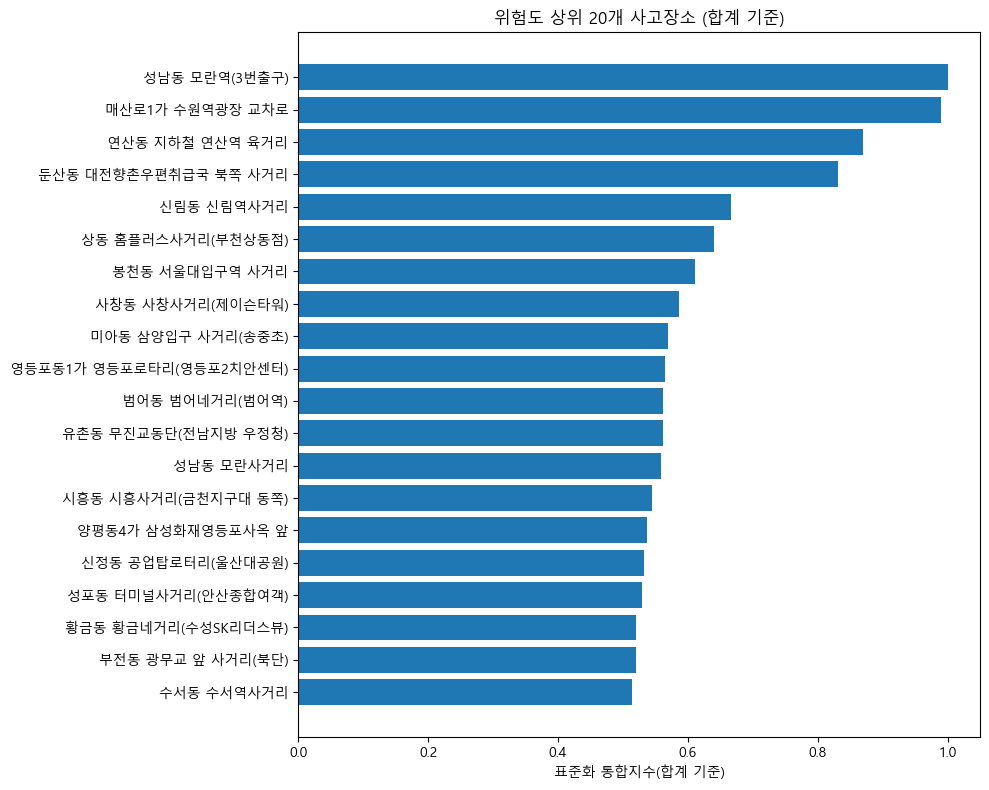

In [13]:
# [셀 7] 상위 위험도 장소 Top20 (합계 기준)
# 목적: 리소스 집중 대상(사고 많고/피해 큰) 장소 파악
top20_sum = agg.sort_values('total_risk_sum_scaled', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(top20_sum['사고장소'][::-1], top20_sum['total_risk_sum_scaled'][::-1])
plt.xlabel('표준화 통합지수(합계 기준)')
plt.title('위험도 상위 20개 사고장소 (합계 기준)')
plt.tight_layout()
plt.show()


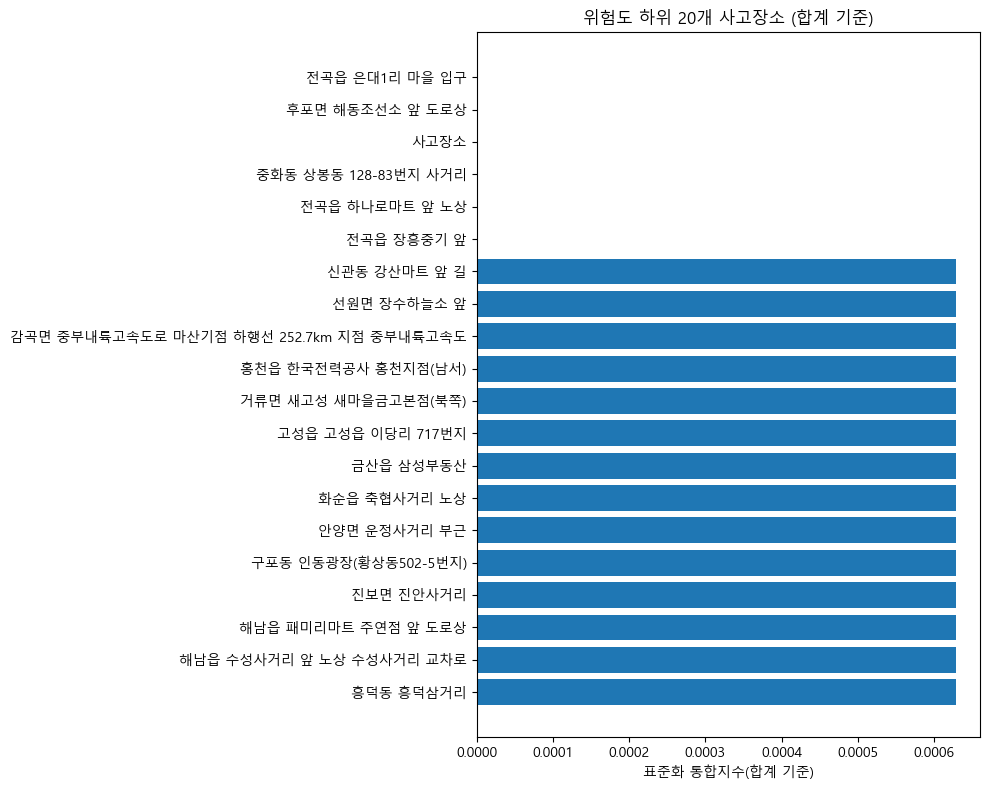

In [14]:
# [셀 8] 하위 위험도 장소 Top20 (합계 기준)
# 목적: 상대적 안전지 파악(벤치마킹)
bottom20_sum = agg.sort_values('total_risk_sum_scaled', ascending=True).head(20)

plt.figure(figsize=(10, 8))
plt.barh(bottom20_sum['사고장소'][::-1], bottom20_sum['total_risk_sum_scaled'][::-1])
plt.xlabel('표준화 통합지수(합계 기준)')
plt.title('위험도 하위 20개 사고장소 (합계 기준)')
plt.tight_layout()
plt.show()


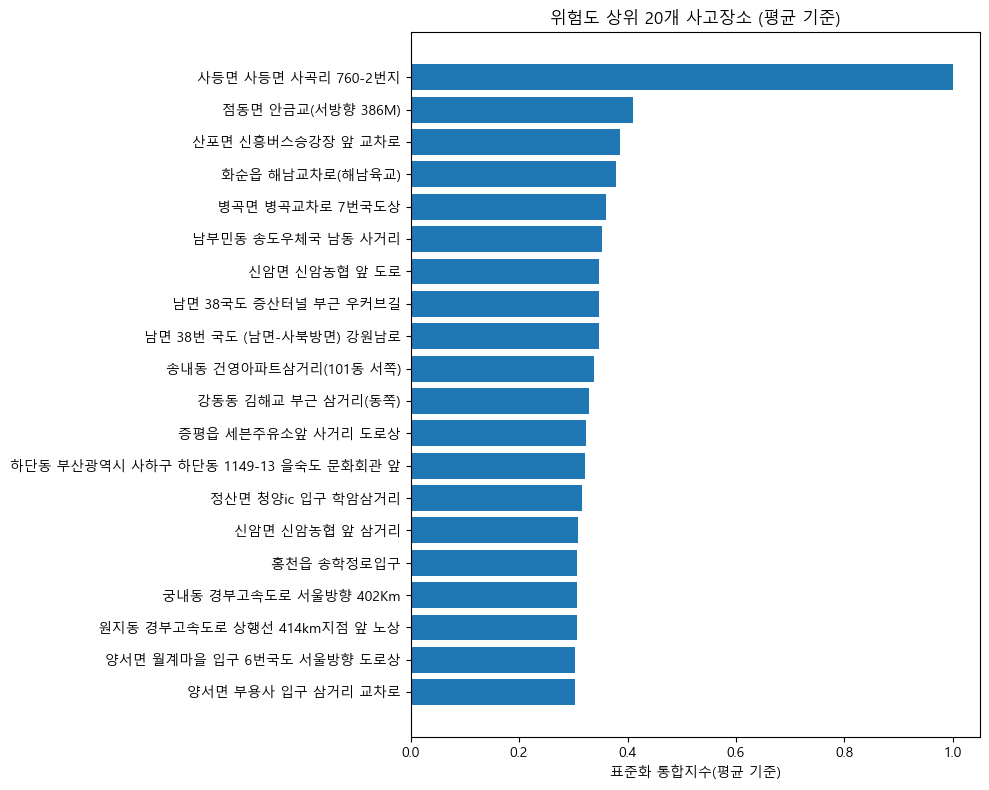

In [15]:
# [셀 9] 평균 기준 Top20
# 목적: '사고 한 건당 강도'가 높은 장소 확인(건수보단 질적인 위험)
top20_mean = agg.sort_values('total_risk_mean_scaled', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(top20_mean['사고장소'][::-1], top20_mean['total_risk_mean_scaled'][::-1])
plt.xlabel('표준화 통합지수(평균 기준)')
plt.title('위험도 상위 20개 사고장소 (평균 기준)')
plt.tight_layout()
plt.show()


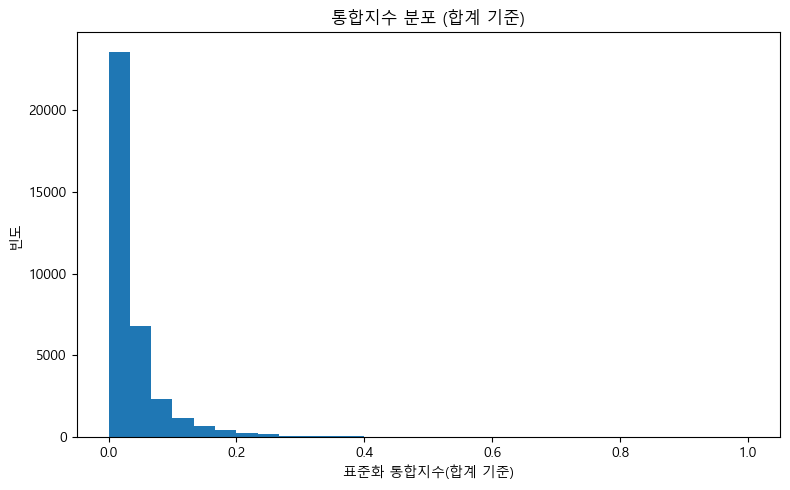

In [16]:
# [셀 10] 분포 확인: 합계 기준 통합지수 히스토그램
# 목적: 전체 위험도 분포 구조 파악(꼬리/이상치 감지)
plt.figure(figsize=(8, 5))
plt.hist(agg['total_risk_sum_scaled'], bins=30)
plt.xlabel('표준화 통합지수(합계 기준)')
plt.ylabel('빈도')
plt.title('통합지수 분포 (합계 기준)')
plt.tight_layout()
plt.show()


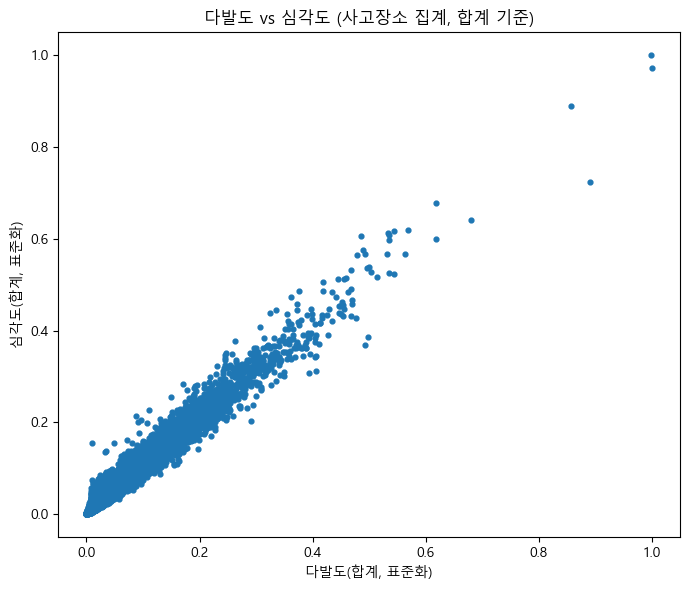

In [17]:
# [셀 11] 다발도 vs 심각도 산점도(합계 기준, 표준화)
# 목적: '많이-가볍게' vs '적게-세게' 구역 구분
plt.figure(figsize=(7, 6))
plt.scatter(agg['incident_score_sum_scaled'], agg['severity_score_sum_scaled'], s=12)
plt.xlabel('다발도(합계, 표준화)')
plt.ylabel('심각도(합계, 표준화)')
plt.title('다발도 vs 심각도 (사고장소 집계, 합계 기준)')
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_3036\1248443654.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=day_order, showfliers=False)


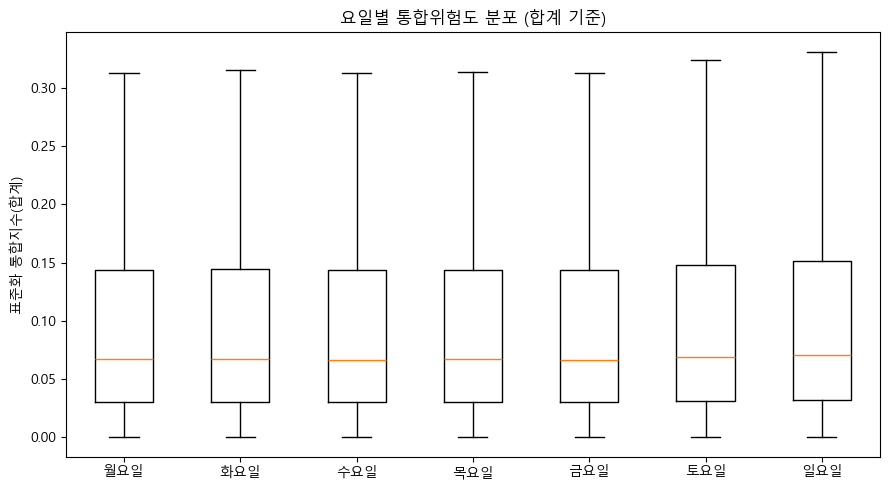

In [18]:
# [셀 12] 요일별 통합지수(합계 관점): 박스플롯
# 목적: 요일 패턴 파악
# 전처리: 원시 df에 요일/시간 있음 -> 사고장소별 통합지수를 원시 df에 브로드캐스트해 요일 집계
day_order = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
tmp = df[['사고장소','사고요일']].copy()
tmp = tmp.merge(agg[['사고장소','total_risk_sum_scaled']], on='사고장소', how='left')

plt.figure(figsize=(9, 5))
data = [tmp.loc[tmp['사고요일']==d, 'total_risk_sum_scaled'].dropna().values for d in day_order]
plt.boxplot(data, labels=day_order, showfliers=False)
plt.ylabel('표준화 통합지수(합계)')
plt.title('요일별 통합위험도 분포 (합계 기준)')
plt.tight_layout()
plt.show()


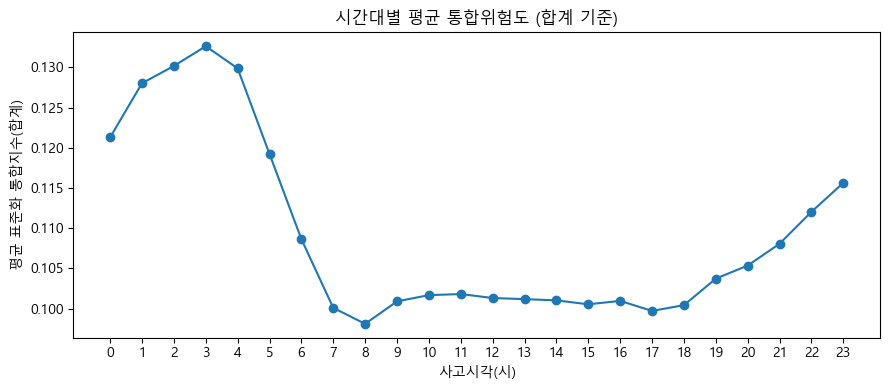

In [19]:
# [셀 13] 시간대별 평균 통합지수(합계 관점)
# 목적: 시간 패턴 파악(야간/출퇴근 등)
df['사고시각'] = pd.to_numeric(df['사고시각'], errors='coerce')  # 0~23 가정
tmp2 = df[['사고장소','사고시각']].copy()
tmp2 = tmp2.merge(agg[['사고장소','total_risk_sum_scaled']], on='사고장소', how='left')

by_hour = tmp2.dropna(subset=['사고시각']).groupby('사고시각')['total_risk_sum_scaled'].mean().reset_index()

plt.figure(figsize=(9, 4))
plt.plot(by_hour['사고시각'], by_hour['total_risk_sum_scaled'], marker='o')
plt.xticks(range(0,24,1))
plt.xlabel('사고시각(시)')
plt.ylabel('평균 표준화 통합지수(합계)')
plt.title('시간대별 평균 통합위험도 (합계 기준)')
plt.tight_layout()
plt.show()


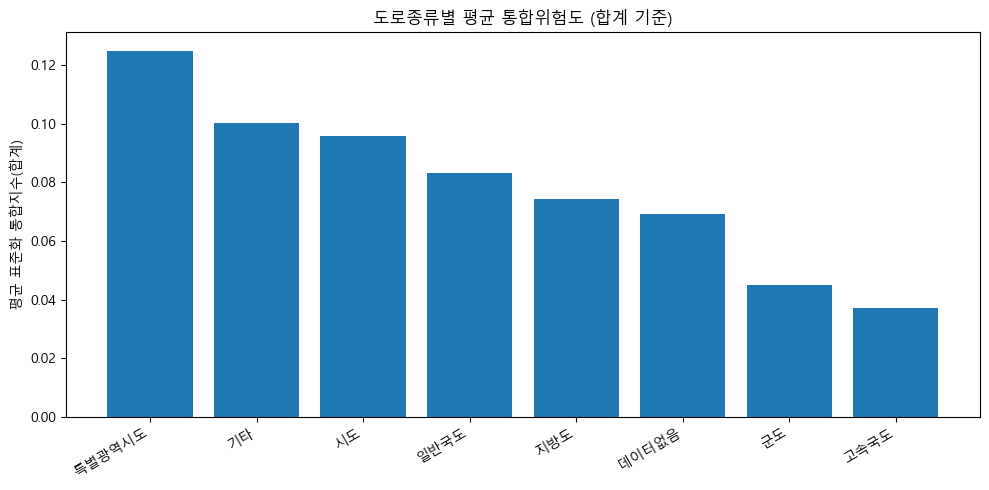

In [20]:
# [셀 14] 도로종류별 평균 통합지수(합계 관점)
# 목적: 유형별 차이 파악(특별/광역시도, 일반국도 등)
tmp3 = df[['사고장소','도로종류']].dropna().copy()
tmp3 = tmp3.merge(agg[['사고장소','total_risk_sum_scaled']], on='사고장소', how='left')
by_road = tmp3.groupby('도로종류')['total_risk_sum_scaled'].mean().reset_index().sort_values('total_risk_sum_scaled', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(by_road['도로종류'], by_road['total_risk_sum_scaled'])
plt.xticks(rotation=30, ha='right')
plt.ylabel('평균 표준화 통합지수(합계)')
plt.title('도로종류별 평균 통합위험도 (합계 기준)')
plt.tight_layout()
plt.show()


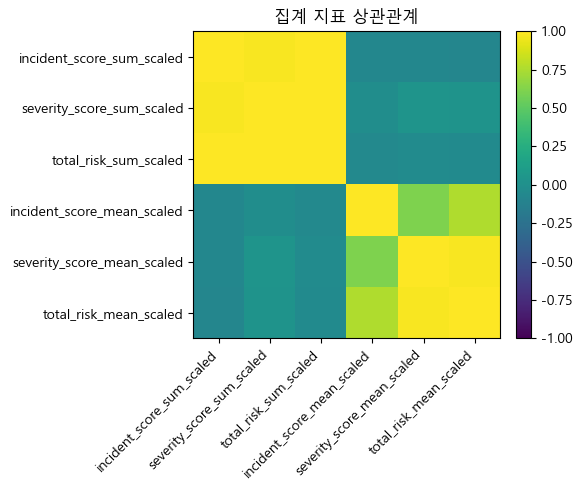

In [21]:
# [셀 15] 상관관계 히트맵(합/평균 스케일드 지표)
# 목적: 지표들 사이의 구조적 관계 확인
cols = ['incident_score_sum_scaled','severity_score_sum_scaled','total_risk_sum_scaled',
        'incident_score_mean_scaled','severity_score_mean_scaled','total_risk_mean_scaled']
corr = agg[cols].corr()

plt.figure(figsize=(6, 5))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.yticks(range(len(cols)), cols)
plt.title('집계 지표 상관관계')
plt.tight_layout()
plt.show()


In [22]:
# [셀 16] 리포트용 테이블 추출(선택)
# 목적: 상위/하위 리스트를 표로 바로 넘길 수 있게 CSV로 저장
out_cols = ['사고장소',
            'incident_score_sum','severity_score_sum','total_risk_sum',
            'incident_score_sum_scaled','severity_score_sum_scaled','total_risk_sum_scaled',
            'incident_score_mean','severity_score_mean','total_risk_mean',
            'incident_score_mean_scaled','severity_score_mean_scaled','total_risk_mean_scaled']

top100_sum = agg.sort_values('total_risk_sum_scaled', ascending=False)[out_cols].head(100)
bottom100_sum = agg.sort_values('total_risk_sum_scaled', ascending=True)[out_cols].head(100)
top100_mean = agg.sort_values('total_risk_mean_scaled', ascending=False)[out_cols].head(100)

top100_sum.to_csv("top100_sum.csv", index=False, encoding="utf-8")
bottom100_sum.to_csv("bottom100_sum.csv", index=False, encoding="utf-8")
top100_mean.to_csv("top100_mean.csv", index=False, encoding="utf-8")

print("리포트 저장 완료: top100_sum.csv, bottom100_sum.csv, top100_mean.csv")


리포트 저장 완료: top100_sum.csv, bottom100_sum.csv, top100_mean.csv
